In [ ]:
!pip install plotly
!pip install numpyro
!pip install seaborn==0.12.2
!pip install --upgrade numpy==1.23.5
!pip install --upgrade scipy==1.12.0
!pip install -U "jax[cuda12_pip]" -fhttps://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install pymc-marketing
!pip install openpyxl
! pip install preliz

In [19]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pymc.sampling_jax
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from pymc_marketing.mmm.transformers import geometric_adstock
from collections import defaultdict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# data sim

In [21]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 179


# data sim

In [22]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)
x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)
x3 = rng.uniform(low=0.0, high=1.0, size=n)
df["x3"] = np.where(x3 > 0.6, x3, x3/3)
x4 = rng.uniform(low=0.0, high=1.0, size=n)
df["x4"] = np.where(x4 > 0.7, x4, x4 / 1.5)


In [23]:
# apply geometric adstock transformation
alpha1: float = 0.7
alpha2: float = 0.3
alpha3: float = 0.5
alpha4: float = 0.4

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x3_adstock"] = (
    geometric_adstock(x=df["x3"].to_numpy(), alpha=alpha3, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x4_adstock"] = (
    geometric_adstock(x=df["x4"].to_numpy(), alpha=alpha4, l_max=8, normalize=True)
    .eval()
    .flatten()
)

In [24]:
def hill_saturation(x, lam, k):
    return  (x**k / (x**k + lam**k))

In [25]:
lam1: float = 0.45
lam2: float = 1.0
lam3: float = 0.5
lam4: float = 0.6

k1 : float = .5
k2 : float  = .7
k3 : float  = .9
k4 : float  = 1.5

df["x1_adstock_saturated"] = hill_saturation(df["x1_adstock"].to_numpy(), lam1, k1)
df["x2_adstock_saturated"] = hill_saturation(df["x2_adstock"].to_numpy(), lam2, k2)
df["x3_adstock_saturated"] = hill_saturation(df["x3_adstock"].to_numpy(), lam3, k3)
df["x4_adstock_saturated"] = hill_saturation(df["x4_adstock"].to_numpy(), lam4, k4)

In [26]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 4.0
beta_2 = 2.0
beta_3 = 2.5
beta_4 = 3.5

df["y"] = amplitude * (
    df["intercept"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + beta_3 * df["x3_adstock_saturated"]
    + beta_4 * df["x4_adstock_saturated"]
    + df["epsilon"]
)

# Modeling

In [27]:
channels_exp_lst = ['x1','x2', 'x3' , 'x4']
target_name = 'y'

In [28]:
total_spend_per_channel = df[['x1', 'x2', 'x3' , 'x4']].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()
spend_share

x1    0.239866
x2    0.125606
x3    0.312313
x4    0.322215
dtype: float64

In [29]:
n_channels = len(channels_exp_lst)
prior_sigma = n_channels * spend_share.to_numpy()
prior_sigma.tolist()

[0.959465464855853, 0.5024222973760709, 1.2492522073590666, 1.2888600304090094]

In [30]:
def scale_data(df, predictor_lst, target_name):

    sclr_trgt = MaxAbsScaler()
    sclr_predictor = MaxAbsScaler()
    sclr_control = StandardScaler()
    data_to_model = df.copy()

    sclr = defaultdict()
    # Scale Target
    sclr['transformer_target'] = MaxAbsScaler().fit(data_to_model[target_name].to_numpy().reshape(-1,1))
    data_to_model[target_name] = sclr['transformer_target'].transform(data_to_model[target_name].to_numpy().reshape(-1,1))

    # Scale Predictors with MaxAbs   
    sclr['transformer_predictor'] = MaxAbsScaler().fit(data_to_model[predictor_lst].to_numpy())
    data_to_model[predictor_lst] = sclr['transformer_predictor'].transform(data_to_model[predictor_lst].to_numpy())

    return data_to_model, sclr

data_sclr, sclr = scale_data(df,  channels_exp_lst, target_name)

#### Data Manipulation

In [31]:
data_to_model_channel = data_sclr.melt(
  id_vars= ['date_week', target_name], 
    value_vars = channels_exp_lst, 
    ).rename(columns= {'variable': 'channel', 'value':'EXP'}, 
            ).pivot_table(
                    index= ['date_week', 'channel'],
                    values= ['EXP', target_name]
                    )

data_to_model_channel = data_to_model_channel.reset_index()
data_to_model_channel['channel'] = pd.Categorical(
    data_to_model_channel['channel'], 
    categories=channels_exp_lst, 
    ordered=True
)

data_to_model_channel = data_to_model_channel.sort_values(by=['date_week', 'channel'])
data_to_model_channel = data_to_model_channel.set_index(['date_week', 'channel'])

### Modeling

# Hill Saturation 2 Parameter

In [34]:
COORDS = {
    'date_week' : df['date_week'].unique(),
    'channel' : channels_exp_lst, 
}

In [35]:
def hill_saturation(x, lam, k):
    return (x**k / (x**k + lam**k))

In [36]:
def calculate_mape(actual, predicted):
    return np.abs((actual - predicted) / actual) * 100

###  Model

Sampling: [beta, err_sigma, int_sigma, intercept, sat_lam, x1_alpha, x1_sat_k, x2_alpha, x2_sat_k, x3_alpha, x3_sat_k, x4_alpha, x4_sat_k, y]


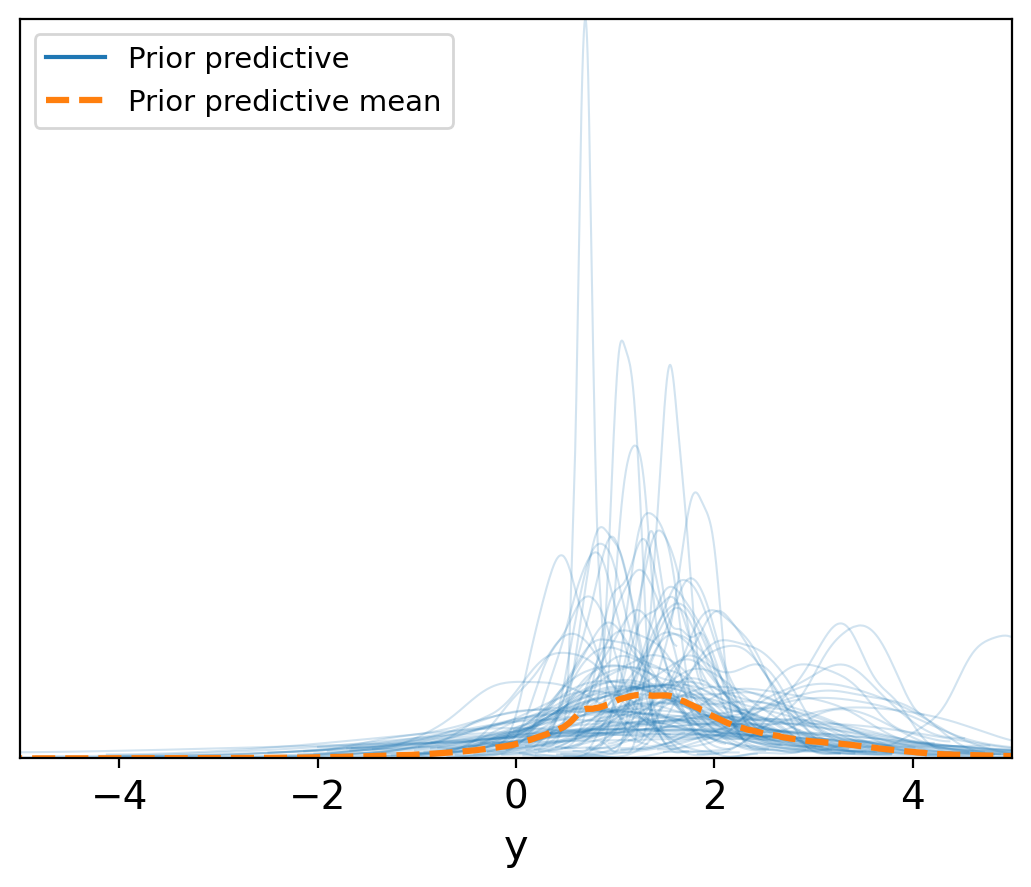

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [int_sigma, intercept, beta, x1_alpha, x2_alpha, x3_alpha, x4_alpha, sat_lam, x1_sat_k, x2_sat_k, x3_sat_k, x4_sat_k, err_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
There were 3288 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

In [46]:
# Scaled modeling
with pm.Model(coords = COORDS) as model:

    ### PYMC Functions
    from pymc_marketing.mmm.components.adstock import GeometricAdstock
    geometric_adstock = GeometricAdstock(l_max= 8, normalize=True)
    
    x_data = pm.Data(
        "x_data",
        value= data_sclr[channels_exp_lst].values,
        dims=("date_week", "channel")
    )
    y_data = pm.Data(
        "y_data",
        value= data_sclr['y'].values, 
        dims= ("date_week" )
    )


    int_sigma = pm.HalfNormal("int_sigma", sigma= .5)

    intercept = pm.HalfNormal("intercept", sigma= int_sigma,)


    beta = pm.HalfNormal('beta',  sigma= prior_sigma, dims = ['channel'])

    x1_alpha = pm.Uniform('x1_alpha', lower = .6, upper = .8)
    x2_alpha = pm.Uniform('x2_alpha', lower = .2, upper = .4)
    x3_alpha = pm.Uniform('x3_alpha', lower = .3, upper = .8)
    x4_alpha = pm.Uniform('x4_alpha', lower = .3, upper = .8)

    adstock_alpha = pm.Deterministic('adstock_alpha', pm.math.stack([x1_alpha, x2_alpha, x3_alpha, x4_alpha]), dims = ["channel"])


    sat_lam = pm.Uniform('sat_lam', lower = 0.1, upper = 1, dims = ['channel'])


    x1_sat_k = pm.Uniform('x1_sat_k', lower = 0.3, upper = 3.0)
    x2_sat_k = pm.Uniform('x2_sat_k', lower = 0.3, upper = 3.0)
    x3_sat_k = pm.Uniform('x3_sat_k', lower = 0.3, upper = 3.0)
    x4_sat_k = pm.Uniform('x4_sat_k', lower = 0.3, upper = 3.0)
    sat_k = pm.Deterministic('sat_k', pm.math.stack([x1_sat_k, x2_sat_k , x3_sat_k, x4_sat_k]), dims = ["channel"])


    adstock_data = geometric_adstock.function(x= x_data, alpha= adstock_alpha)
    saturated_data = hill_saturation(x= adstock_data, 
                                         lam = sat_lam, 
                                         k = sat_k
                                        )

    channel_contributions = pm.Deterministic(
        name= "channel_contributions",
        var = (saturated_data * beta) ,
        dims= ("date_week", "channel")
    )

    y_pred = intercept  + (channel_contributions).sum(axis=1) 
    err_sigma= pm.HalfNormal('err_sigma', sigma= 1) 




    pm.Normal(
        name = target_name, mu = y_pred, 
        sigma = err_sigma, 
        dims= ("date_week"),
        observed= y_data)

    ppc_mmm = pm.sample_prior_predictive(samples = 100, random_seed=3333)
    fig, ax = plt.subplots()
    az.plot_ppc(ppc_mmm, group="prior", num_pp_samples=100, ax = ax)
    ax.set_xlim([-5, 5])
    ax.set_ylim([0, 5])
    plt.show()
    
    idata_mmm = pm.sample(1000, tune=1000)

    pm.sample_posterior_predictive(idata_mmm, extend_inferencedata= True, random_seed= 123)

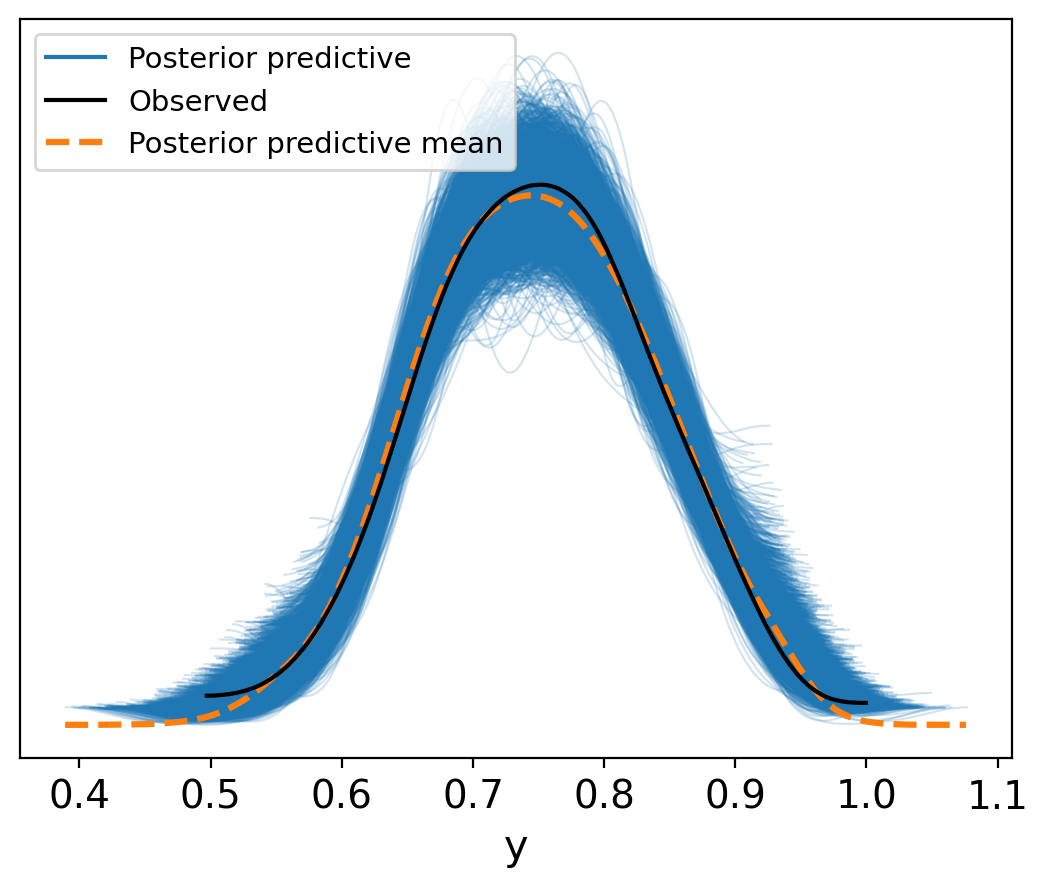

In [24]:
az.plot_ppc(idata_mmm)
plt.show()

In [49]:
# saturation parameters
# True: lam = .45, 1,  0.5, 0.6
#         k =.5 0.7 , 0.9, 1.5
az.summary(idata_mmm, var_names= ['sat_lam','sat_k'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sat_lam[x1],0.551,0.238,0.208,1.000,0.007,0.005,1081.0,1583.0,1.01
sat_lam[x2],0.198,0.102,0.100,0.342,0.008,0.006,282.0,204.0,1.02
sat_lam[x3],0.357,0.226,0.100,0.834,0.009,0.006,699.0,946.0,1.00
sat_lam[x4],0.689,0.158,0.436,0.966,0.007,0.005,533.0,885.0,1.01
sat_k[x1],0.911,0.550,0.300,2.030,0.026,0.018,535.0,996.0,1.01
sat_k[x2],1.169,0.185,1.000,1.522,0.008,0.006,441.0,1220.0,1.01
sat_k[x3],0.807,0.472,0.300,1.705,0.019,0.013,528.0,917.0,1.00
sat_k[x4],1.613,0.316,1.124,2.240,0.014,0.010,539.0,803.0,1.00


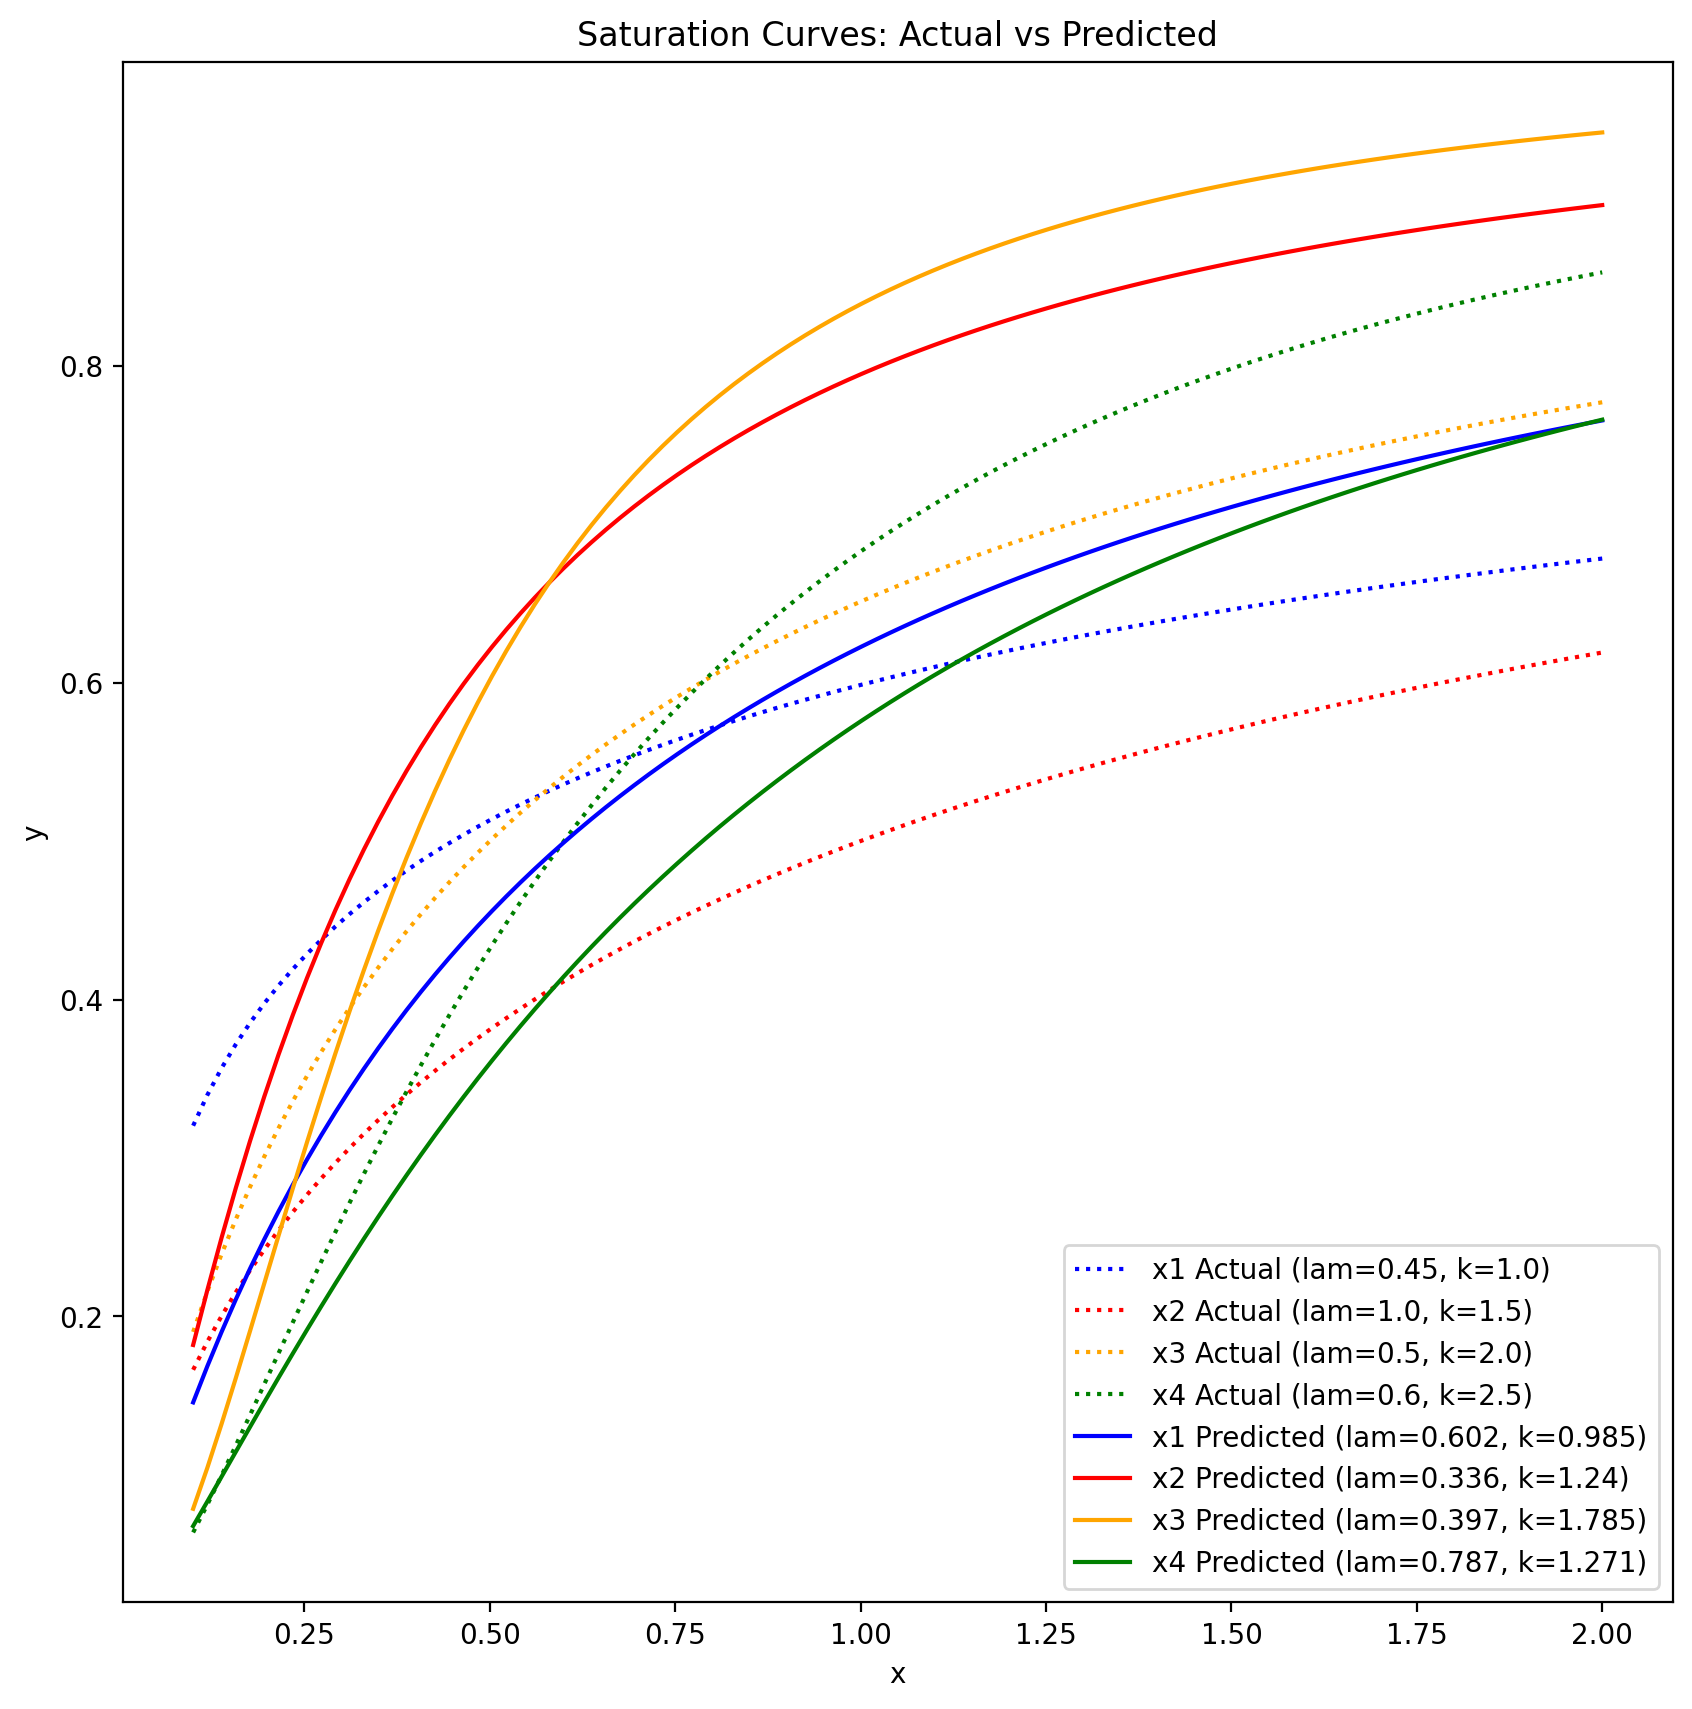

In [43]:
curve_params = az.summary(idata_mmm, var_names=['sat_lam', 'sat_k'])
lam1_pred = curve_params.loc['sat_lam[x1]', 'mean']
lam2_pred = curve_params.loc['sat_lam[x2]', 'mean']
lam3_pred = curve_params.loc['sat_lam[x3]', 'mean']
lam4_pred = curve_params.loc['sat_lam[x4]', 'mean']

k1_pred = curve_params.loc['sat_k[x1]', 'mean']
k2_pred = curve_params.loc['sat_k[x2]', 'mean']
k3_pred = curve_params.loc['sat_k[x3]', 'mean']
k4_pred = curve_params.loc['sat_k[x4]', 'mean']

x = np.linspace(0.1, 2, 100) 

y1 = hill_saturation(x, lam1, k1)
y2 = hill_saturation(x, lam2, k2)
y3 = hill_saturation(x, lam3, k3)
y4 = hill_saturation(x, lam4, k4)

pred_y1 = hill_saturation(x, lam1_pred, k1_pred)
pred_y2 = hill_saturation(x, lam2_pred, k2_pred)
pred_y3 = hill_saturation(x, lam3_pred, k3_pred)
pred_y4 = hill_saturation(x, lam4_pred, k4_pred)


plt.figure(figsize=(10, 10))
plt.plot(x, y1, label="x1 Actual (lam=0.45, k=1.0)", color='blue', linestyle='dotted')
plt.plot(x, y2, label="x2 Actual (lam=1.0, k=1.5)", color='red', linestyle='dotted')
plt.plot(x, y3, label="x3 Actual (lam=0.5, k=2.0)", color='orange', linestyle='dotted')
plt.plot(x, y4, label="x4 Actual (lam=0.6, k=2.5)", color='green', linestyle='dotted')


plt.plot(x, pred_y1, label=f"x1 Predicted (lam={lam1_pred}, k={k1_pred})", color='blue')
plt.plot(x, pred_y2, label=f"x2 Predicted (lam={lam2_pred}, k={k2_pred})", color='red')
plt.plot(x, pred_y3, label=f"x3 Predicted (lam={lam3_pred}, k={k3_pred})", color='orange')
plt.plot(x, pred_y4, label=f"x4 Predicted (lam={lam4_pred}, k={k4_pred})", color='green')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Saturation Curves: Actual vs Predicted')
plt.legend()
plt.show()

In [44]:
lam_preds = [lam1_pred, lam2_pred, lam3_pred, lam4_pred]
lam_actuals = [lam1, lam2, lam3, lam4]

lam_mape = [calculate_mape(lam_actuals[i], lam_preds[i]) for i in range(4)]

lam_mape_df = pd.DataFrame({
    'lam': [f'lam{i+1}' for i in range(4)],
    'actual': lam_actuals,
    'pred' : lam_preds,
    'mape': lam_mape
})

lam_mape_df

,lam,actual,pred,mape
0,lam1,0.45,0.602,33.777778
1,lam2,1.00,0.336,66.400000
2,lam3,0.50,0.397,20.600000
3,lam4,0.60,0.787,31.166667


In [45]:
k_preds = [k1_pred, k2_pred, k3_pred, k4_pred]
k_actuals = [k1, k2 , k3, k4]

k_mape = [calculate_mape(k_actuals[i], k_preds[i]) for i in range(4)]

k_mape_df = pd.DataFrame({
    'k': [f'k{i+1}' for i in range(4)],
    'actual': k_actuals,
    'pred' : k_preds,
    'mape': k_mape
})

k_mape_df

,k,actual,pred,mape
0,k1,0.5,0.985,97.000000
1,k2,0.7,1.240,77.142857
2,k3,0.9,1.785,98.333333
3,k4,1.5,1.271,15.266667
